In [1]:
!pip install easycolab
import easycolab as ec
ec.mount()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Opening directory /content/gdrive/My Drive/
Done!


In [0]:
import torch
from torch import nn
import torch.utils.data as torch_data
from torchvision import transforms
from torchvision import models
import torchvision
from tqdm import tqdm
import numpy as np
import os
import random
import PIL
import matplotlib.pyplot as plt
import time

In [0]:
class create_set(torch_data.Dataset):
    def __init__(self, path_X, path_y,transform=None):
        super(create_set, self).__init__()
        
        self.X=sorted(os.listdir(path_X))
        self.y=sorted(os.listdir(path_y))
        self.transform=transform
        self.path_X=path_X
        self.path_y=path_y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X=PIL.Image.open(os.path.join(self.path_X,self.X[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        y=PIL.Image.open(os.path.join(self.path_y,self.y[idx])).crop((0, 138, 768, 906.0)).resize((256,256)) 
        if self.transform is not None:
            rand=np.random.randint(10**9)
            random.seed(rand)
            X=self.transform(X)
            random.seed(rand)
            y=self.transform(y)
        return X, y

In [0]:
train_set=create_set('./data/trainX', './data/trainY', transform=transforms.Compose([
        transforms.ToTensor()
        ]))

In [0]:
class create_set(torch_data.Dataset):
    def __init__(self, path_X, path_y,transform=None):
        super(create_set, self).__init__()       
        self.X=sorted(os.listdir(path_X))[0:3]
        self.y=sorted(os.listdir(path_y))[0:3]
        self.transform=transform
        self.path_X=path_X
        self.path_y=path_y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X=PIL.Image.open(os.path.join(self.path_X,self.X[idx])).crop((0, 138, 768, 906.0)) 
        y=PIL.Image.open(os.path.join(self.path_y,self.y[idx])).crop((0, 138, 768, 906.0))
        if self.transform is not None:
            rand=np.random.randint(10**9)
            random.seed(rand)
            X=self.transform(X)
            random.seed(rand)
            y=self.transform(y)
        return X, y

In [0]:
test_set=create_set('./testX/', './testY/', 
                    transform=transforms.Compose([transforms.ToTensor()]))

In [0]:
train_loader = torch_data.DataLoader(train_set, batch_size=1, shuffle=True) 


In [0]:
test_loader = torch_data.DataLoader(test_set, batch_size=1, shuffle=False)

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
import time
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10
from torchvision.utils import save_image

In [0]:
class CDAutoEncoderFirstLayer(nn.Module):
    r"""
    Convolutional denoising autoencoder first layer for stacked autoencoders.
    """
    def __init__(self, input_size, output_size, stride):
        super(CDAutoEncoderFirstLayer, self).__init__()

        self.forward_pass = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, stride=stride, padding=1),
            nn.ReLU(),
        )
        self.backward_pass = nn.Sequential(
            nn.ConvTranspose2d(output_size, input_size, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
        )

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.1)


    def forward(self, x,y):

        x_noisy = x
        encoded = self.forward_pass(x_noisy)

        if self.training:
          decoded = self.backward_pass(encoded)
          loss = self.criterion(decoded,Variable(y, requires_grad=False))
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
        
        return encoded.detach()

    def reconstruct(self, x):
        return self.backward_pass(x)



class CDAutoEncoder(nn.Module):
    r"""
    Convolutional denoising autoencoder layer for stacked autoencoders.
    """
    def __init__(self, input_size, output_size, stride):
        super(CDAutoEncoder, self).__init__()

        self.forward_pass = nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, stride=stride, padding=1),
            nn.ReLU(),
          
        )
        self.backward_pass = nn.Sequential(
            nn.ConvTranspose2d(output_size, input_size, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            
        )

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)


    def forward(self, x):
        encoded = self.forward_pass(x)

        if self.training:
          decoded = self.backward_pass(encoded)
          loss = self.criterion(decoded,Variable(x, requires_grad=False))
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()
            
        return encoded.detach()

    def reconstruct(self, x):
        return self.backward_pass(x)


class StackedAutoEncoder(nn.Module):
    r"""
    A stacked autoencoder made from the convolutional denoising autoencoders above.
    Each autoencoder is trained independently and at the same time.
    """

    def __init__(self):
        super(StackedAutoEncoder, self).__init__()

        self.ae1 = CDAutoEncoderFirstLayer(3, 64, 1)
        self.ae2 = CDAutoEncoder(64, 128, 1)
        self.ae3 = CDAutoEncoder(128, 256, 1)

    def forward(self, x,y):
        a1= self.ae1(x,y)
        a2= self.ae2(a1)
        a3= self.ae3(a2)

        return a3, self.reconstruct(a3)

    def reconstruct(self, x):
        a2_reconstruct = self.ae3.reconstruct(x)
        a1_reconstruct = self.ae2.reconstruct(a2_reconstruct)
        x_reconstruct = self.ae1.reconstruct(a1_reconstruct)
        return x_reconstruct

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epochs = 30
autoencoder = StackedAutoEncoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0001)

In [0]:
def train(epochs, net, criterion, optimizer, trainload, testloader, scheduler=None, verbose=True):
    start = time.time()
    net.to(device)
    best_val_loss = float('+inf')
    for epoch in range(epochs):
        running_loss = 0.0
        net.train()

        for i, (X, y) in enumerate(trainload):
            X = Variable(X).to(device)
            y=y.to(device)
            _, decoded = net(X,y)
            loss = criterion(decoded, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        running_loss_val = 0.0
        net.eval()
        for i, (X,y) in enumerate(testloader):
 
            X = Variable(X).to(device)
            y=y.to(device)
            _,decoded = net(X,y)
            val_loss = criterion(decoded, y)

            running_loss_val+=val_loss.item()
        if scheduler is not None:
            scheduler.step()
        freq = max(epochs//20,1)
        if verbose and epoch%freq==0:
            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, running_loss, running_loss_val))

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          torch.save(net.state_dict(), 'best_model_SDAE.pth')

    end = time.time()
    print(f"Time cost for training (in seconds): {end-start}")

In [13]:
train(epochs, autoencoder, criterion, optimizer, train_loader, test_loader,  scheduler=None, verbose=True)

Epoch 0/30 || Loss:  Train 9.5337 | Validation 0.0145
Epoch 1/30 || Loss:  Train 0.6926 | Validation 0.0133
Epoch 2/30 || Loss:  Train 0.4359 | Validation 0.0130
Epoch 3/30 || Loss:  Train 0.6580 | Validation 0.0122
Epoch 4/30 || Loss:  Train 0.4198 | Validation 0.0119
Epoch 5/30 || Loss:  Train 0.3944 | Validation 0.0121
Epoch 6/30 || Loss:  Train 0.3927 | Validation 0.0122
Epoch 7/30 || Loss:  Train 0.3658 | Validation 0.0122
Epoch 8/30 || Loss:  Train 0.3942 | Validation 0.0121
Epoch 9/30 || Loss:  Train 0.3752 | Validation 0.0123
Epoch 10/30 || Loss:  Train 0.3643 | Validation 0.0124
Epoch 11/30 || Loss:  Train 0.3706 | Validation 0.0130
Epoch 12/30 || Loss:  Train 0.3538 | Validation 0.0126
Epoch 13/30 || Loss:  Train 0.3479 | Validation 0.0126
Epoch 14/30 || Loss:  Train 0.3526 | Validation 0.0126
Epoch 15/30 || Loss:  Train 0.3216 | Validation 0.0123
Epoch 16/30 || Loss:  Train 0.3209 | Validation 0.0130
Epoch 17/30 || Loss:  Train 0.3139 | Validation 0.0122
Epoch 18/30 || Loss:

In [14]:
state_dict = torch.load('best_model_SDAE.pth')
autoencoder.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
running_loss_val = 0.0
i = 0
decoded_pics = []

with torch.no_grad():
    for (X,y) in test_loader:
        X = Variable(X).to(device)
        y=y.to(device)
        i += 1
        _,decoded = autoencoder.forward(X,y)
        decoded_pics.append(decoded)
        loss_val = criterion(decoded, y)
        running_loss_val += loss_val.data
print(running_loss_val)

tensor(0.0119, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 768, 768])
torch.Size([1, 3, 768, 768])
torch.Size([1, 3, 768, 768])


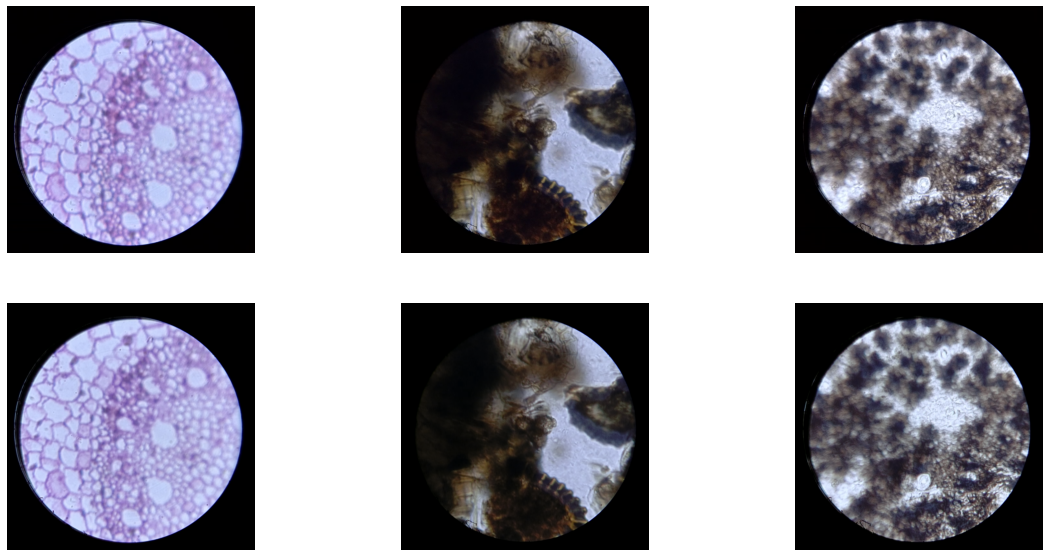

In [18]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

for i, (X,y) in enumerate(test_loader):
    im = X
    print(im.shape)
    ax[0, i].imshow(im.cpu().numpy().transpose([0, 2, 3, 1]).reshape(768, 768,3));
    ax[1, i].imshow(decoded_pics[i].cpu().numpy().transpose([0, 2, 3, 1]).reshape(768, 768,3))
    ax[0, i].axis('off')
    ax[1, i].axis('off')



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


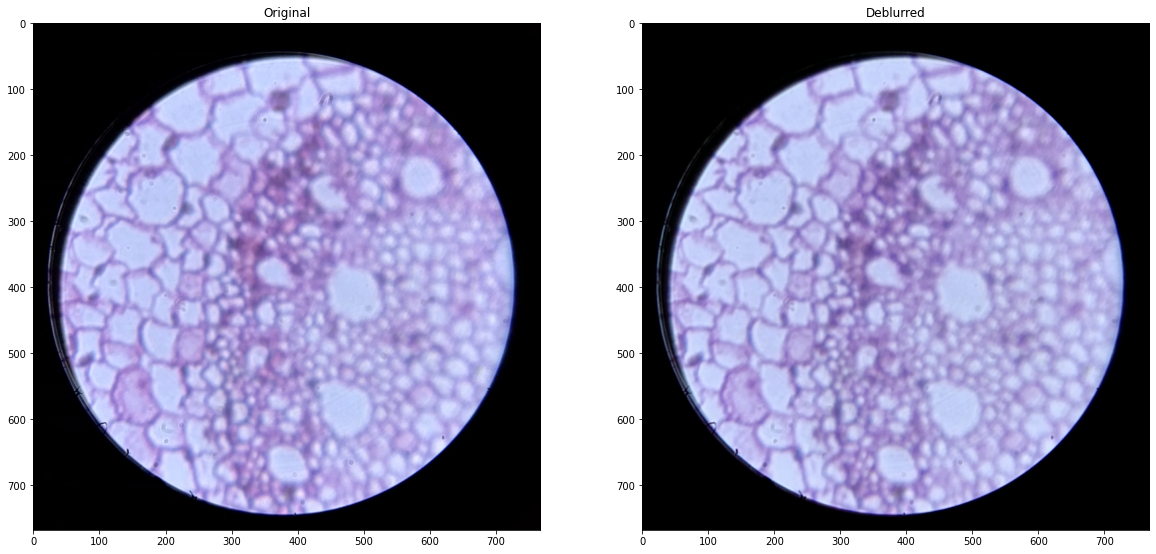

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


For decoded image: 6.0020153895658 0.2432551867991064


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


For initial image: 5.973303871468866 0.24339630554036465


In [24]:
from skimage import measure

plt.figure(figsize=(20,10))

for i, (X,y) in enumerate(test_loader):
  if i==0:
    plt.subplot(1,2,1)
    pic1=X.cpu().numpy().transpose([0, 2, 3, 1]).reshape(768, 768,3)
    plt.imshow(pic1);
    plt.title("Original")
    plt.subplot(1,2,2)

    pic2=decoded_pics[i].cpu().numpy().transpose([0, 2, 3, 1]).reshape(768, 768,3)
    plt.imshow(pic2)
    plt.title("Deblurred")
    plt.show()
    psnr_for_decoded=measure.compare_psnr(y.cpu().numpy().reshape(768, 768,3),pic2)
    ssim_for_decoded=measure.compare_ssim(y.cpu().numpy().reshape(768, 768,3),pic2,multichannel=True)
    print("For decoded image:", psnr_for_decoded, ssim_for_decoded)
    psnr_for_initial=measure.compare_psnr(y.cpu().numpy().reshape(768, 768,3),pic1)
    ssim_for_initial=measure.compare_ssim(y.cpu().numpy().reshape(768, 768,3),pic1,multichannel=True)
    print("For initial image:", psnr_for_initial, ssim_for_initial)